## **Capstone MDS - ADABoost**

#### **_Integrantes:_**  

1. Evans Díaz   
1. Felipe Ojeda
1. Javier Cofre  
1. Luis Reinoso

In [1]:
# importar librerías
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from matplotlib.ticker import EngFormatter

In [2]:
# función cálculo R2, RMSE y MSE
def R2_RMSE(y_true, y_pred):
  # cálculo de R2 y RMSE
  r2 = r2_score(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  
  return print('R2:',r2), print('RMSE:',rmse), print('MSE:', mse)

## **_1. Lectura (carga) de los Datos_**

In [3]:
# importamos archivo
#df = pd.read_csv('../Data/df_final_pay_sin_mt.csv')


# importamos archivo desde github (ojo que la rama se llama master)
df = pd.read_csv('https://raw.githubusercontent.com/ecdiazl/capstone-project/master/Data/df_final_pay_sin_mt.csv')

In [4]:
# miramos el dataframe
df.head()

,year_2023,year_2024,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,CAT 798-AC,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS
0,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0
1,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,396.0,96.0,240.0,0.0,132.0,24.0
2,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,394.0,96.0,240.0,0.0,132.0,24.0
3,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,95.0,396.0,96.0,240.0,0.0,132.0,24.0
4,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0


In [5]:
# información general df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 84 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_2023            1567 non-null   bool   
 1   year_2024            1567 non-null   bool   
 2   month_2              1567 non-null   bool   
 3   month_3              1567 non-null   bool   
 4   month_4              1567 non-null   bool   
 5   month_5              1567 non-null   bool   
 6   month_6              1567 non-null   bool   
 7   month_7              1567 non-null   bool   
 8   month_8              1567 non-null   bool   
 9   month_9              1567 non-null   bool   
 10  month_10             1567 non-null   bool   
 11  month_11             1567 non-null   bool   
 12  month_12             1567 non-null   bool   
 13  day_2                1567 non-null   bool   
 14  day_3                1567 non-null   bool   
 15  day_4                1567 non-null   b

## **_2 Preparación del DataFrame_**

In [6]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
for col in df.columns:
  if df[col].dtype == 'bool':
     df[col] = df[col].astype('category').cat.codes
     df[col] = df[col].astype('category') # para que quede como category y no como int8

In [7]:
print('Nombre Columnas: ',df.columns)
print('Cantidad Columnas: ',len(df.columns))

Nombre Columnas:  Index(['year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21',
       'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28',
       'day_29', 'day_30', 'day_31', 'shift_B', 'crew_E2', 'crew_E3',
       'crew_E4', 'total', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'elec_excl', 'som_excl', 'demora', 'r_prog',
       'r_noprg', 'waiting', 'queued', 'payload', 'distance', 'distance_down',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ',
       'KOM.96

In [8]:
# cálculamos la desviaicón estándar y la media de payload
std_y = df['payload'].std()
mean_y = df['payload'].mean()

print('Desviación Estándar:',std_y)
print('Media:',mean_y)

Desviación Estándar: 19936.05577427206
Media: 142357.4639507874


In [9]:
# estandarizamos las variables numéricas
col_num = df.drop('payload', axis=1).select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

## **_3 ADABoost_**

In [10]:
# definimos el tamaño del set de test
test_size = 0.10

In [11]:
# separamos los datos en X e y
X = df.drop('payload', axis=1)
y = df['payload']

# dividimos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 

In [12]:
# Crear un regresor de árbol de decisión como modelo base, con un solo nodo de decisión (profundidad = 1)
base_estimator = DecisionTreeRegressor(max_depth=1)

In [13]:
# Inicializar el regresor AdaBoost
ada_boost_reg = AdaBoostRegressor(estimator=base_estimator, 
                                  n_estimators=50, 
                                  learning_rate=1.0, 
                                  random_state=42)

In [14]:
# Entrenar el modelo AdaBoost
ada_boost_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1), random_state=42)

In [15]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_train = ada_boost_reg.predict(X_train)

In [16]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_train, predictions_train)

R2: 0.46668511530409607
RMSE: 14546.06542137326
MSE: 211588019.24287084


(None, None, None)

In [17]:
# Realizar predicciones con el modelo entrenado
predictions_test = ada_boost_reg.predict(X_test)

In [18]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test, predictions_test)

R2: 0.5163524264691837
RMSE: 13875.870240825427
MSE: 192539774.94022468


(None, None, None)

## _4 Optimización del Modelo_ 

### _4.1 Selección de Variables (LassoCV)_

In [19]:
# buscamos alpha optimo con LassoCV
alpha_values = np.linspace(0.01, 300, 30000)

# Crea un objeto LassoCV
lasso_cv = LassoCV(alphas=alpha_values, cv=5)

# Ajusta el modelo a los datos de entrenamiento
lasso_cv.fit(X_train, y_train)

# Valor óptimo de alpha
best_alpha = lasso_cv.alpha_

# Evalúa el modelo en el conjunto de prueba
score = lasso_cv.score(X_test, y_test)

print(f"Mejor valor de alpha: {best_alpha}")
print(f"Puntuación en el conjunto de prueba: {score}")

/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45464268.828811646, tolerance: 44797657.82579975
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46388205.88165283, tolerance: 44797657.82579975
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47209431.48269653, tolerance: 44797657.82579975
  model = cd_fast.enet_coordinate_de

Mejor valor de alpha: 28.770000000000003
Puntuación en el conjunto de prueba: 0.7525238681971774


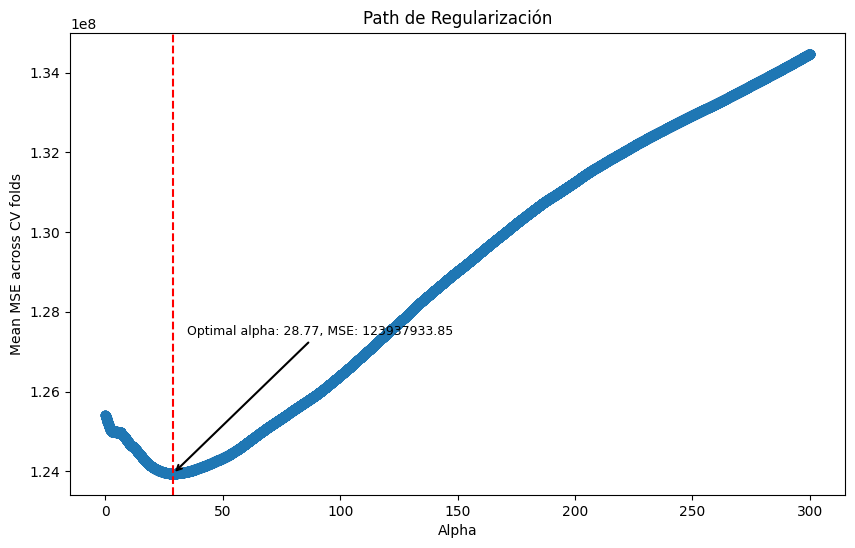

In [20]:
# Graficar MSE vs. Alpha
plt.figure(figsize=(10,6))
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), '-o')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE across CV folds')
plt.title('Path de Regularización')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')

# Anotar el valor óptimo de alpha en el gráfico
plt.annotate(f'Optimal alpha: {lasso_cv.alpha_:.2f}, MSE: {np.min(np.mean(lasso_cv.mse_path_, axis=1)):.2f}',
             xy=(lasso_cv.alpha_, np.min(np.mean(lasso_cv.mse_path_, axis=1))),
             xycoords='data', xytext=(10,100), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", lw=1.5),
             fontsize=9)

plt.show()

In [21]:
# Aplicar Lasso para la selección de características
lasso = Lasso(alpha=lasso_cv.alpha_)  
lasso.fit(X_train, y_train)

# Seleccionar las características que tienen coeficientes no nulos
selected_features = X_train.columns[lasso.coef_ != 0]

print("Características seleccionadas:")
print(selected_features)


Características seleccionadas:
Index(['year_2023', 'year_2024', 'month_3', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_10', 'day_11', 'day_13', 'day_15', 'day_16',
       'day_17', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_26', 'day_27', 'day_28', 'day_30', 'day_31', 'shift_B', 'crew_E2',
       'crew_E3', 'crew_E4', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'demora', 'r_noprg', 'waiting', 'queued',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ',
       'KOM.960E5', 'Kom.930E-4', 'Kom.930E-4SE', 'Kom.930ER-MT', 'Kom.980E5',
       'Komatsu AHS'],
      dtype='object')


In [22]:
len(selected_features)

64

> Volvemos ajustar el modelo con las variables seleccionadas

In [23]:
# separamos los datos en train y test
X_lasso= df[selected_features]
y_lasso = df['payload']

# dividimos los datos en train y test
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=test_size, random_state=42)

In [24]:
# Inicializar el regresor AdaBoost
ada_boost_reg_lasso = AdaBoostRegressor(estimator=base_estimator, 
                                  n_estimators=50, 
                                  learning_rate=1.0, 
                                  random_state=42)

In [25]:
# Entrenar el modelo AdaBoost
ada_boost_reg_lasso.fit(X_train_lasso, y_train_lasso)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1), random_state=42)

#### 4.1.1 Predicciones en el conjunto de entrenamiento

In [26]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_train = ada_boost_reg_lasso.predict(X_train_lasso)

In [27]:
# Evaluar la precisión del modelo
mse = mean_squared_error(y_train_lasso, predictions_lasso_train)
print(f'Mean Squared Error of AdaBoost Regressor: {mse:.2f}')

Mean Squared Error of AdaBoost Regressor: 207392789.00


In [28]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_train)

R2: 0.4772593375219846
RMSE: 14401.138461884646
MSE: 207392788.99837327


(None, None, None)

#### 4.1.2 Predicciones en el conjunto de testeo

In [29]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_test = ada_boost_reg_lasso.predict(X_test_lasso)

In [30]:
# Evaluar la precisión del modelo
mse = mean_squared_error(y_test_lasso, predictions_lasso_test)
print(f'Mean Squared Error of AdaBoost Regressor: {mse:.2f}')

Mean Squared Error of AdaBoost Regressor: 189233764.22


In [31]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_test)

R2: 0.5246569134936971
RMSE: 13756.226380095433
MSE: 189233764.22043353


(None, None, None)

### _4.2 Optimización de Hiperparámetros_

In [32]:
# Definir los hiperparámetros para la búsqueda
param_dist_tree = {
    'max_depth': randint(1, 200),
    'min_samples_split': randint(2, 200),
    'min_samples_leaf': randint(1, 200)
}

# Crear la búsqueda de hiperparámetros para DecisionTreeRegressor
random_search_tree = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(),
    param_distributions=param_dist_tree,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
random_search_tree.fit(X_train_lasso, y_train_lasso)

# Mejor combinación de hiperparámetros para el árbol de decisión
best_params_tree = random_search_tree.best_params_
print("Best parameters for DecisionTreeRegressor: ", best_params_tree)


Best parameters for DecisionTreeRegressor:  {'max_depth': 132, 'min_samples_leaf': 2, 'min_samples_split': 135}


In [33]:
# Crear el DecisionTreeRegressor con los mejores parámetros encontrados
best_tree = DecisionTreeRegressor(**best_params_tree)

# Crear el modelo AdaBoost con el mejor DecisionTreeRegressor como base
ada_boost = AdaBoostRegressor(estimator=best_tree)

# Definir los hiperparámetros para la búsqueda de AdaBoost
param_dist_boost = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.001, 2.0),
    'loss': ['linear', 'square', 'exponential']
}

# Crear la búsqueda de hiperparámetros para AdaBoostRegressor
random_search_boost = RandomizedSearchCV(
    estimator=ada_boost,
    param_distributions=param_dist_boost,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
random_search_boost.fit(X_train_lasso, y_train_lasso)

# Mejor combinación de hiperparámetros para AdaBoost
best_params_boost = random_search_boost.best_params_
print("Best parameters for AdaBoostRegressor: ", best_params_boost)

Best parameters for AdaBoostRegressor:  {'learning_rate': np.float64(0.901998503939086), 'loss': 'square', 'n_estimators': 437}


In [34]:
# Crear el modelo AdaBoost con los mejores hiperparámetros encontrados
best_boost = AdaBoostRegressor(estimator=best_tree, **best_params_boost)

# Entrenar el modelo AdaBoost con los mejores hiperparámetros
best_boost.fit(X_train_lasso, y_train_lasso)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=132,
                                                  min_samples_leaf=2,
                                                  min_samples_split=135),
                  learning_rate=np.float64(0.901998503939086), loss='square',
                  n_estimators=437)

In [35]:
# Realizar predicciones en el conjunto de entrenamiento
train_predictions = best_boost.predict(X_train_lasso)

# Realizar predicciones en el conjunto de prueba
test_predictions = best_boost.predict(X_test_lasso)

In [36]:
# Evaluar el modelo en el conjunto de entrenamiento
train_r2 = r2_score(y_train_lasso, train_predictions)
train_mse = mean_squared_error(y_train_lasso, train_predictions)
train_rmse = np.sqrt(train_mse)

print(f"R2 en el conjunto de entrenamiento: {train_r2:.3f}")
print(f"MSE en el conjunto de entrenamiento: {train_mse:.2f}")
print(f"RMSE en el conjunto de entrenamiento: {train_rmse:.2f}")

R2 en el conjunto de entrenamiento: 0.816
MSE en el conjunto de entrenamiento: 73153713.13
RMSE en el conjunto de entrenamiento: 8552.99


In [37]:
# Evaluar el modelo en el conjunto de prueba
test_r2 = r2_score(y_test_lasso, test_predictions)
test_mse = mean_squared_error(y_test_lasso, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"R2 en el conjunto de prueba: {test_r2:.3f}")
print(f"MSE en el conjunto de prueba: {test_mse:.2f}")
print(f"RMSE en el conjunto de prueba: {test_rmse:.2f}")

R2 en el conjunto de prueba: 0.739
MSE en el conjunto de prueba: 104031214.20
RMSE en el conjunto de prueba: 10199.57


### _4.3 Importancia de las Variables_

#### 4.3.1 Método Shapley 

In [43]:
# Crear un muestreo de fondo para el kernelExplainer
background = shap.sample(X_train_lasso, 100)

# Crear el objeto explainer SHAP con el modelo entrenado
explainer = shap.KernelExplainer(best_boost.predict, background)
shap_values = explainer(X_test_lasso)

# Visualizar la importancia de las características
shap.summary_plot(shap_values, 
                  X_test_lasso, 
                  feature_names=X_test_lasso.columns, 
                  plot_type='bar', 
                  color='skyblue',
                  max_display=10,
                  plot_size=(10, 10))

# Mostrar la gráfica
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

#### 4.3.2 Método Feature Importance

In [ ]:
# Mostrar importancia de las características
df_importance = pd.DataFrame({'Feature':X_train_lasso.columns, 
                              'Importance':best_boost.feature_importances_})

# Ordenar las características por importancia
df_importance = df_importance.sort_values('Importance', ascending=False)
df_importance